# Forest Fire Bayesian Regression
Nikki Aaron, Amanda West, Beverly Dobrenz  


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import arviz as az
import warnings
warnings.filterwarnings('ignore')

az.style.use('arviz-darkgrid')
az.rcParams['plot.max_subplots'] = 60  # Increase max number of plots to show in notebook

random_seed=57

## Portugal Forest Fire Data Set
Source: http://archive.ics.uci.edu/ml/datasets/Forest+Fires

In [2]:
# Read data file
path = '.'
file = 'forestfires.csv'
df = pd.read_csv(f'{path}/{file}')

## Numeric Variable Distributions

KDE plots show the approximate distribution of data in each column from the data set. We can see that most are approximately normally distributed with a few outliers. Burn area and rainfall are skewed with many values equal to zero.

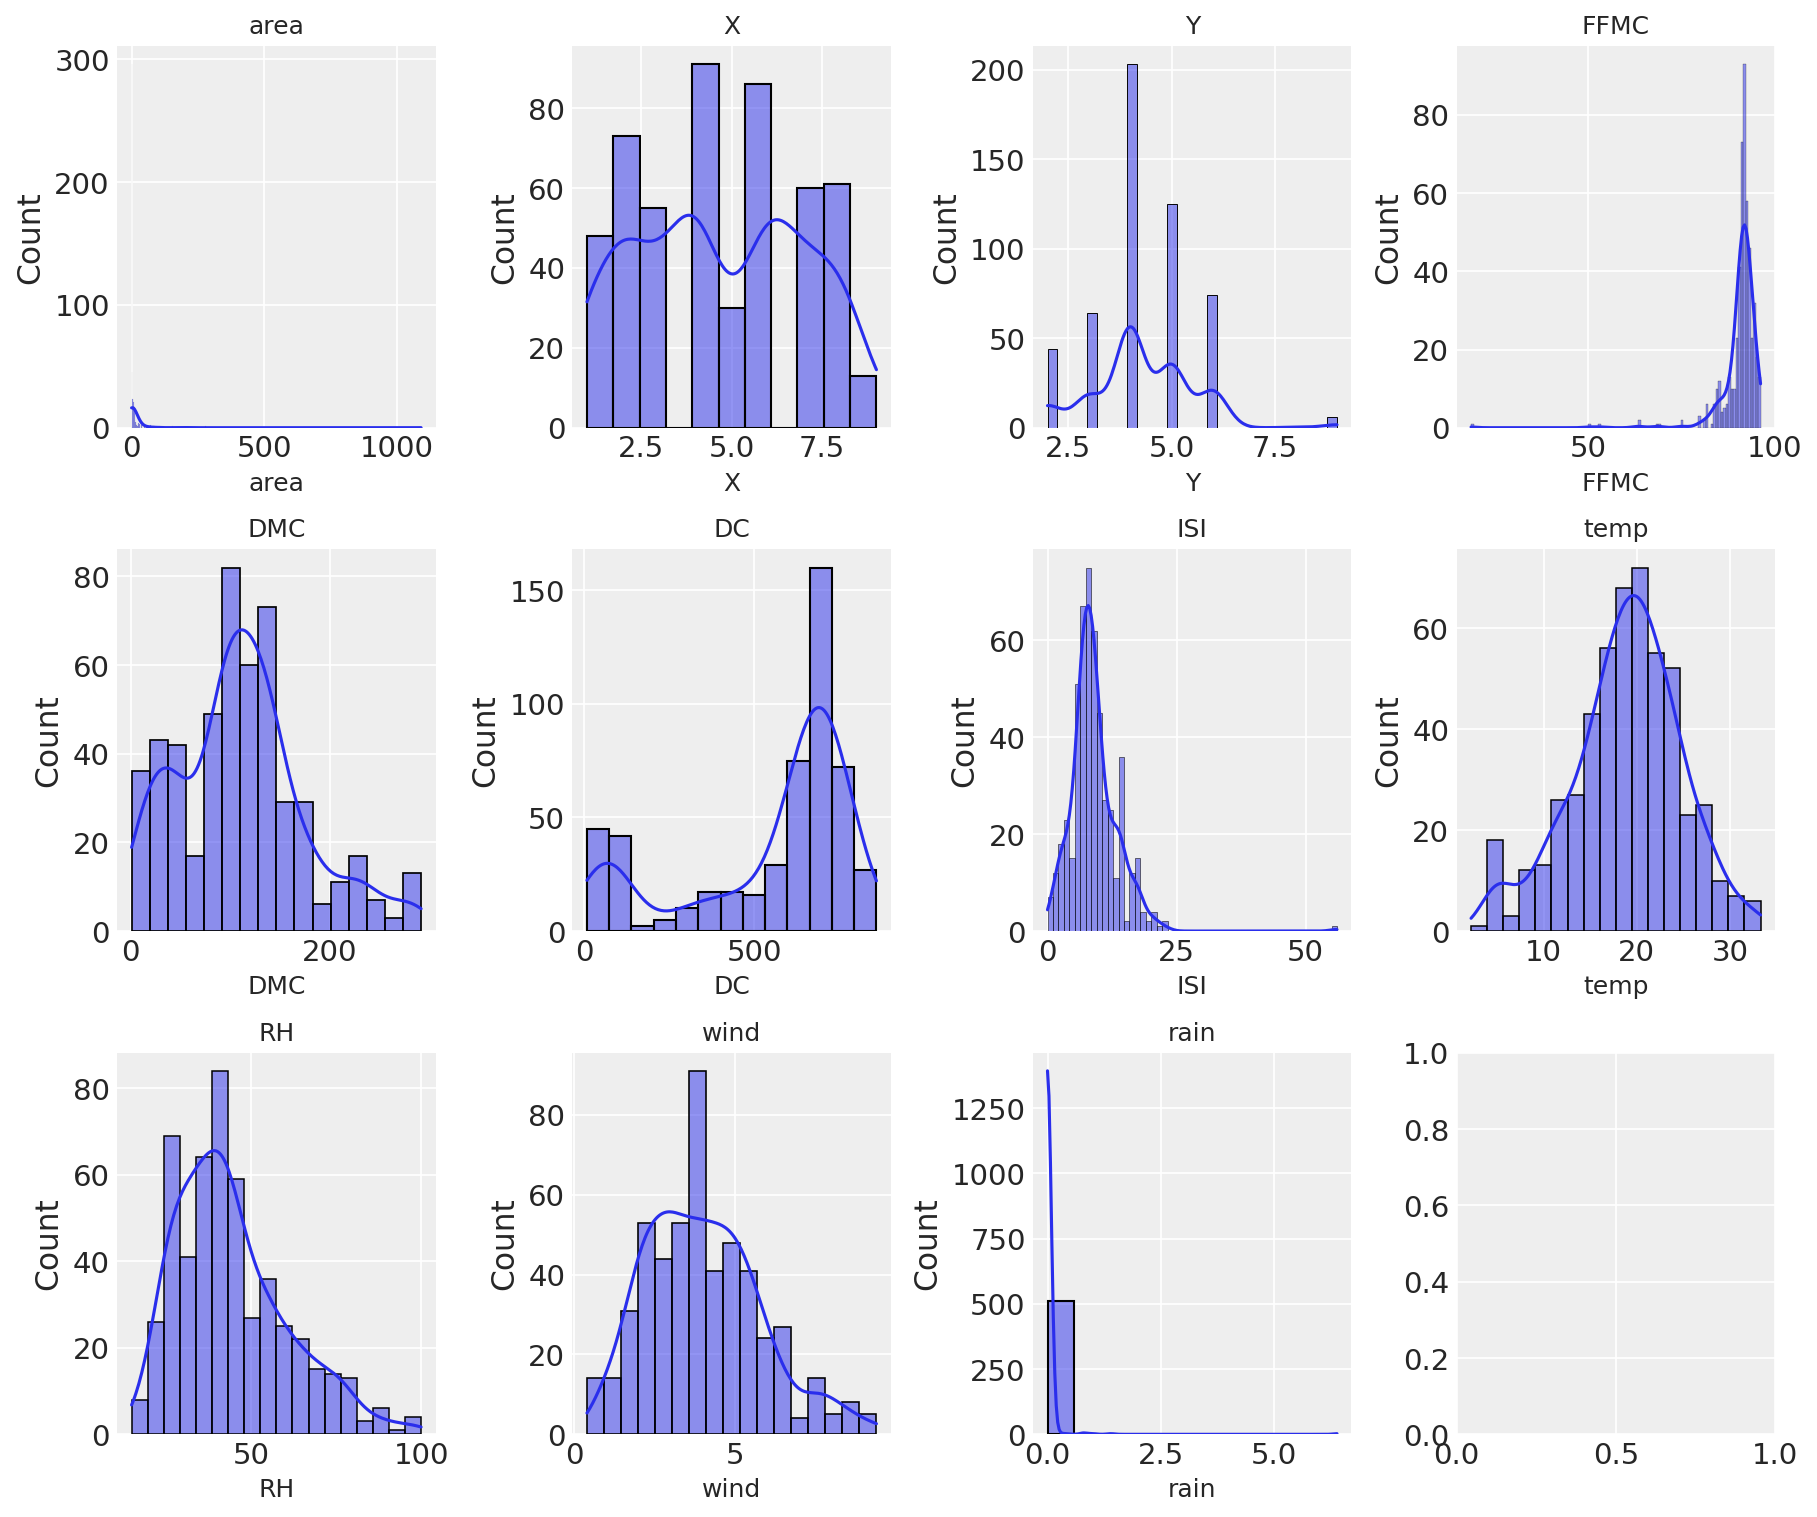

In [3]:
fig, axes = plt.subplots(3,4, figsize=(12,10), dpi=150)

for ax, data, xlabel in zip(fig.axes,
                               [df[col] for col in ['area', 'X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']],
                               ['area', 'X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']):
    sns.histplot(data, ax=ax, kde=True)
    ax.set_title(xlabel, fontsize=12)
    ax.set_xlabel(xlabel, fontsize=12)

## Categorical Variable Distributions

Violin plots show the distribution of the log transformed burn area for each day of the week and month over multiple years. There does not seem to be a significant difference in burn area per day of the week, but we can see there are a lot more fires and fires with larger burn areas in the months of August and September. This makes sense because those are Portugal's hotter, drier summer months.

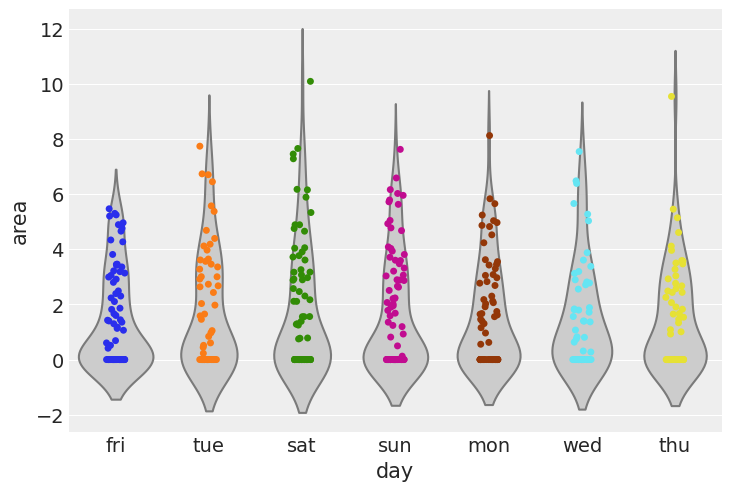

In [4]:
ax = sns.violinplot(x=df['day'], y=np.log2(df['area'] + 1), inner=None, color=".8")
ax = sns.stripplot(x=df['day'], y=np.log2(df['area'] + 1), jitter=True)

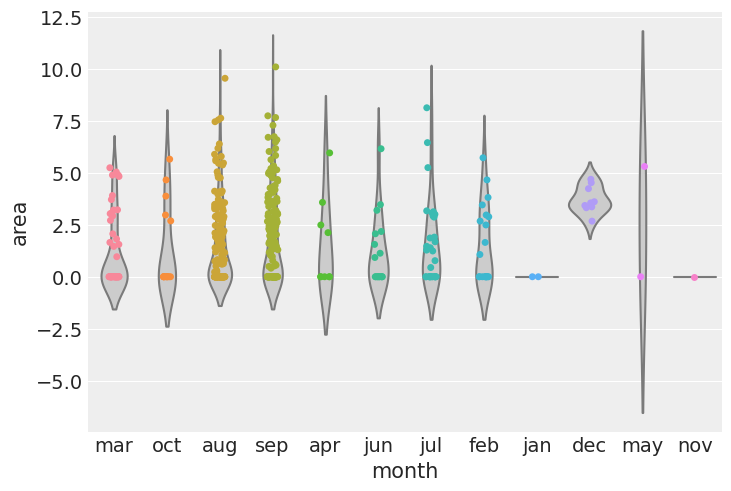

In [5]:
ax = sns.violinplot(x=df['month'], y=np.log2(df['area'] + 1), inner=None, color=".8")
ax = sns.stripplot(x=df['month'], y=np.log2(df['area'] + 1), jitter=True)

## Variable Correlations
Pair plots were created to show correlations between pairs of variables. The only clear correlation are between temperature and relative humidity, and between some of the Fire Weather Indices.  

We can see that most days have no burn area (fire) at all, and two large fires stand out as outliers. We can also see that it looks like we have more fires and higher burn area with low relative humidity, high temperature, high FFMC, adn high DC.

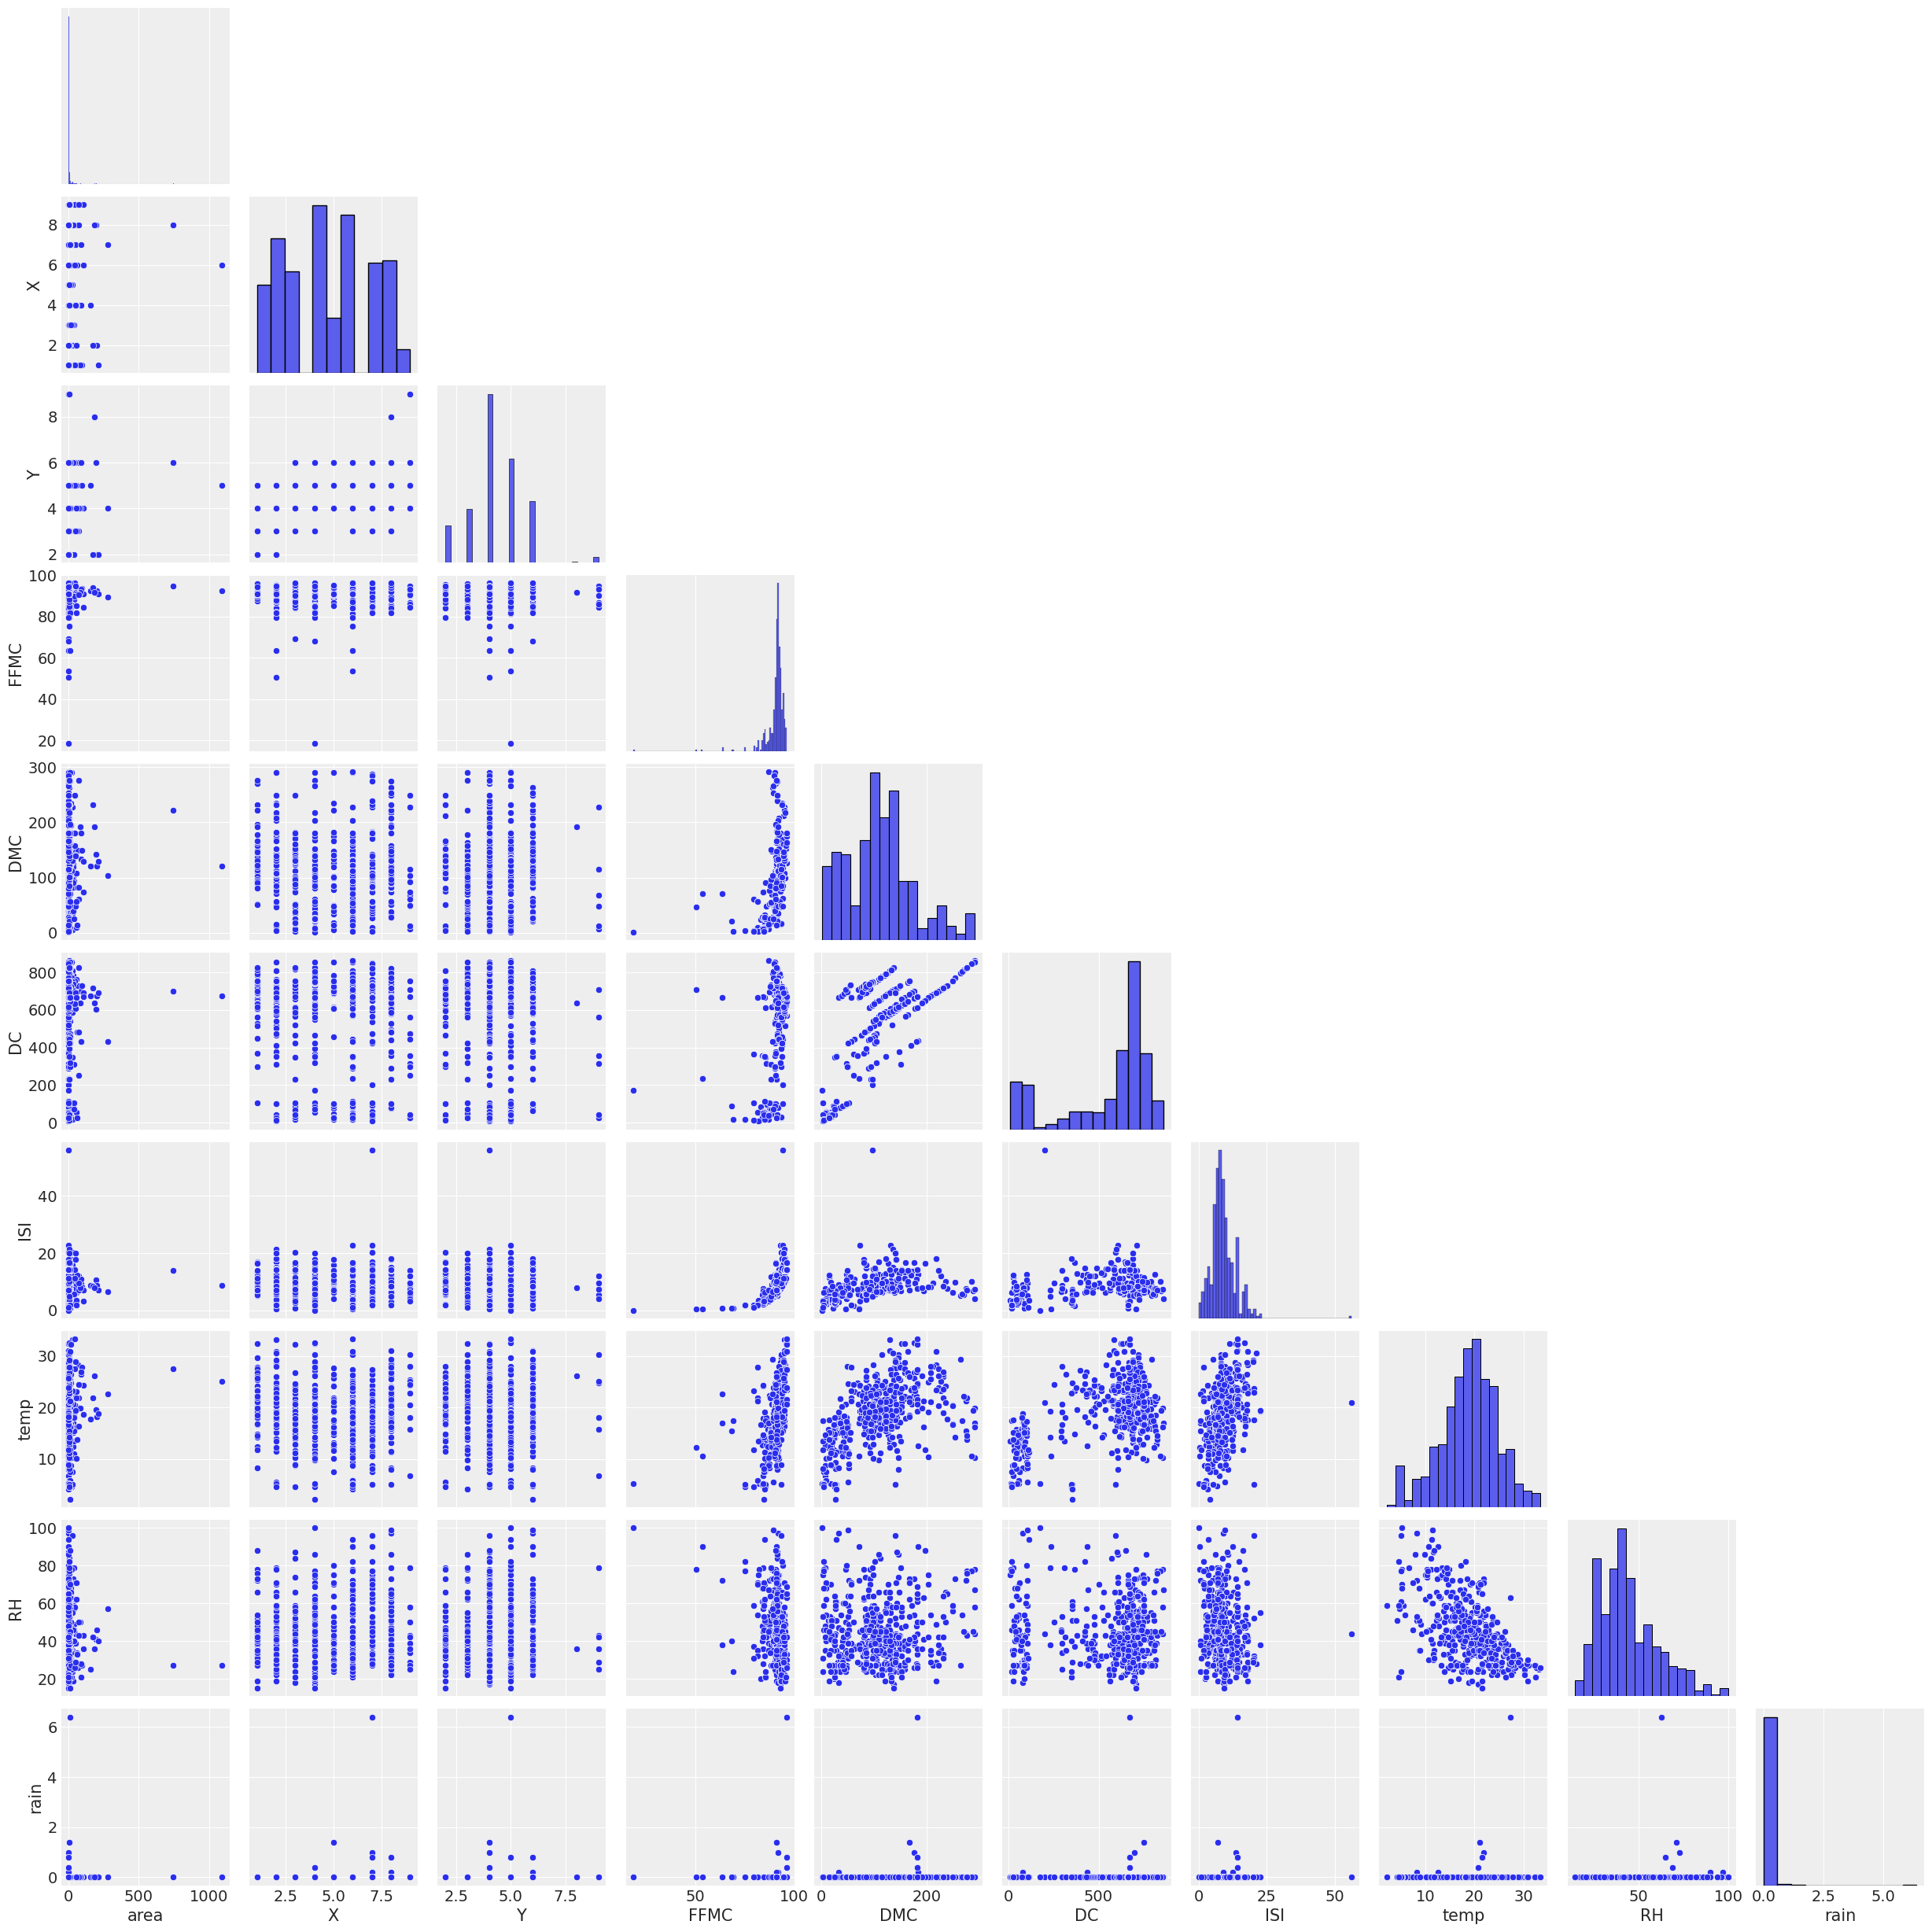

In [6]:
sns.pairplot(df[['area', 'X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'rain']], corner=True);

## Feature Selection and Transformation
For a logistic model on whether a fire occurred, we create a binary response variable 'is_fire'.  
For a linear model on a subset of data where fires did occur, we log transform the burn area response variable so that it better fits a Gaussian distribution.

X and Y predictors were dropped as these did not have a significant contribution to fire occurrence or burn area. Month was dropped because some months (November through January) suffered from insufficient data over the range of the response. Day was dropped because it had no significant contribution to the response except when one large outlier fire on a Saturday skewed the predictor is_saturday dummy coded predictor to significance.

In [7]:
# Cap outliers
df['rain'] = np.clip(df['rain'], None, df['rain'].quantile(0.999))
df['FFMC'] = np.clip(df['FFMC'], df['FFMC'].quantile(0.001), None)
df['ISI'] = np.clip(df['ISI'], None, df['ISI'].quantile(0.999))
df['area'] = np.clip(df['area'], None, df['area'].quantile(0.999))

# add boolean fire column
df['is_fire'] = np.where(df['area'] == 0, 0, 1)

# add boolean weekend from days, and add season by combining months

df['season'] = df['month'].replace({'mar': 'spring',
                                    'apr': 'spring',
                                    'may': 'spring',
                                    'jun': 'summer',
                                    'jul': 'summer',
                                    'aug': 'summer',
                                    'sep': 'fall',
                                    'oct': 'fall',
                                    'nov': 'fall',
                                    'dec': 'winter',
                                    'jan': 'winter',
                                    'feb': 'winter'})

df['weekend'] = np.where(df['day'].isin(['sat', 'sun']), 1, 0).astype('bool')

# Columns for Logistic Model

x_logistic = df[['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain', 'weekend']]
y_logistic = df['is_fire']

# Columns for Linear Model

df_linear = df[df['is_fire'] == 1] # select only rows where a fire occurred
df_linear['area_log'] = np.log2(df['area']) # log transform response variable
x_linear = df_linear[['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain', 'weekend']]
y_linear = df_linear['area_log']

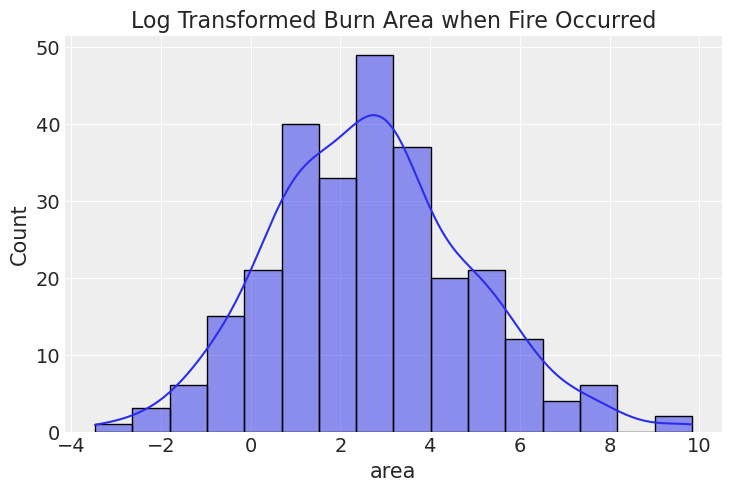

In [8]:
sns.histplot(np.log2(df[df['area'] > 0]['area']), kde=True).set_title("Log Transformed Burn Area when Fire Occurred");

## Data Preparation
To prepare the data for modeling, numeric columns were standardized and categorical columns were dummy coded

In [9]:
# Standardize numeric columns
# to mean 0 variance 1

def standardize(df):
    result = df.copy()
    # standardize numeric
    for feature_name in df.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64']).columns:
        mean = df[feature_name].mean()
        std = df[feature_name].std()
        result[feature_name] = (df[feature_name] - mean) / std
    # change boolean to unstandardized binary
    for feature_name in df.select_dtypes(include=['bool']).columns:
        result[feature_name] = df[feature_name].astype('int')
    return result

x_logistic_standardized = standardize(x_logistic)
x_linear_standardized = standardize(x_linear)

In [10]:
# Dummy code categorical columns

x_logistic_dummies = pd.get_dummies(x_logistic_standardized)
x_linear_dummies = pd.get_dummies(x_linear_standardized)
x_logistic_dummies

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,weekend
0,-0.870743,-1.322045,-1.828706,-0.910975,-1.840857,0.411326,1.497164,-0.087053,0
1,-0.014846,-1.178399,0.488418,-0.536120,-0.153130,-0.691786,-1.740070,-0.087053,0
2,-0.014846,-1.048806,0.560173,-0.536120,-0.738668,-0.691786,-1.516813,-0.087053,1
3,0.199129,-1.211188,-1.896429,0.002735,-1.823636,3.230391,-0.009824,0.957174,0
4,-0.267725,-0.930142,-1.796859,0.143305,-1.289763,3.352959,-1.237741,-0.087053,1
...,...,...,...,...,...,...,...,...,...
512,-1.765545,-0.845829,0.474309,-1.660685,1.534597,-0.753070,-0.735411,-0.087053,1
513,-1.765545,-0.845829,0.474309,-1.660685,0.518517,1.637006,0.994835,-0.087053,1
514,-1.765545,-0.845829,0.474309,-1.660685,0.397965,1.575722,1.497164,-0.087053,1
515,0.724338,0.548471,0.269122,0.541589,1.155720,-0.140230,-0.009824,-0.087053,1


In [11]:
x_logistic_dummies.columns

Index(['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain', 'weekend'], dtype='object')

In [12]:
x_linear_dummies.columns

Index(['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain', 'weekend'], dtype='object')

## Bayesian Logistic Model
Find the probability of a fire occurring

In [13]:
k = x_logistic_dummies.shape[1] # number of predictors

with pm.Model() as logistic_model:
    
    # Intercept term & prior
    beta0 = pm.Normal('beta0', mu=0, sd=1)
    # Beta coefficients for predictor variables & priors
    beta = pm.MvNormal('beta', mu=np.zeros(k), cov=np.eye(k), shape=k)
       
    # Calculate the logit 
    mu = beta0 + pm.math.dot(x_logistic_dummies, beta)
    theta = pm.Deterministic('theta',  pm.invlogit(mu))
    # Pass the logits to a Bernoulli outcome, with the observed data
    y_hat = pm.Bernoulli('y_hat', p=theta, observed=y_logistic) 
    
    # Sample
    trace_main_logistic = pm.sample(10000, cores = 1, random_seed=random_seed)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, beta0]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 63 seconds.


### Graphical Representation of Model

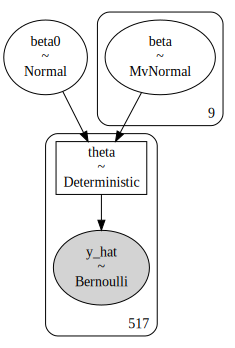

In [14]:
# The graphical model
pm.model_to_graphviz(logistic_model)

### Coefficient Distributions

Forest plots show that DC, and wind are the only siginificant predictors since their 90% HCI do not cross a mean of 0. DC has a posiive coefficient so fire risk increases with it. This is not surprising since DC measures drought conditions with higher numbers being drier conditions which can help fires start. Wind also has a positive coeffient, and so fires are more likely on windier days.


| Coefficient | Variable |
|-|-|
| Beta0 | Intercept |
| Beta 0 | FFMC |
| Beta 1 | DMC |
| Beta 2 | DC |
| Beta 3 | ISI |
| Beta 4 | Temperature |
| Beta 5 | RH |
| Beta 6 | Wind |
| Beta 7 | Rain |
| Beta 8 | Weekend |

In [15]:
# Results in table
with logistic_model:
    main_idata = az.from_pymc3(trace_main_logistic)
az.summary(main_idata, var_names=['beta0','beta'], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta0,0.13,0.11,-0.08,0.35,0.0,0.0,21809.52,17403.18,21788.34,15946.68,1.0
beta[0],0.12,0.14,-0.14,0.38,0.0,0.0,21474.14,14553.50,21790.51,14790.26,1.0
beta[1],-0.06,0.14,-0.32,0.19,0.0,0.0,22606.88,12722.61,22603.59,15338.69,1.0
beta[2],0.20,0.13,-0.03,0.46,0.0,0.0,23165.90,18609.21,23201.65,14869.94,1.0
beta[3],-0.07,0.12,-0.30,0.16,0.0,0.0,21665.17,15515.40,21678.02,16398.65,1.0
beta[4],0.12,0.15,-0.16,0.41,0.0,0.0,18684.51,15283.09,18691.51,15494.09,1.0
beta[5],0.02,0.13,-0.22,0.25,0.0,0.0,17847.21,12959.60,17853.51,15524.17,1.0
beta[6],0.19,0.10,0.01,0.37,0.0,0.0,24145.71,21542.23,24100.89,15301.05,1.0
beta[7],0.01,0.12,-0.22,0.24,0.0,0.0,25232.43,7288.38,26806.27,11965.67,1.0
beta[8],-0.13,0.19,-0.50,0.22,0.0,0.0,21438.05,14436.32,21433.01,15236.29,1.0


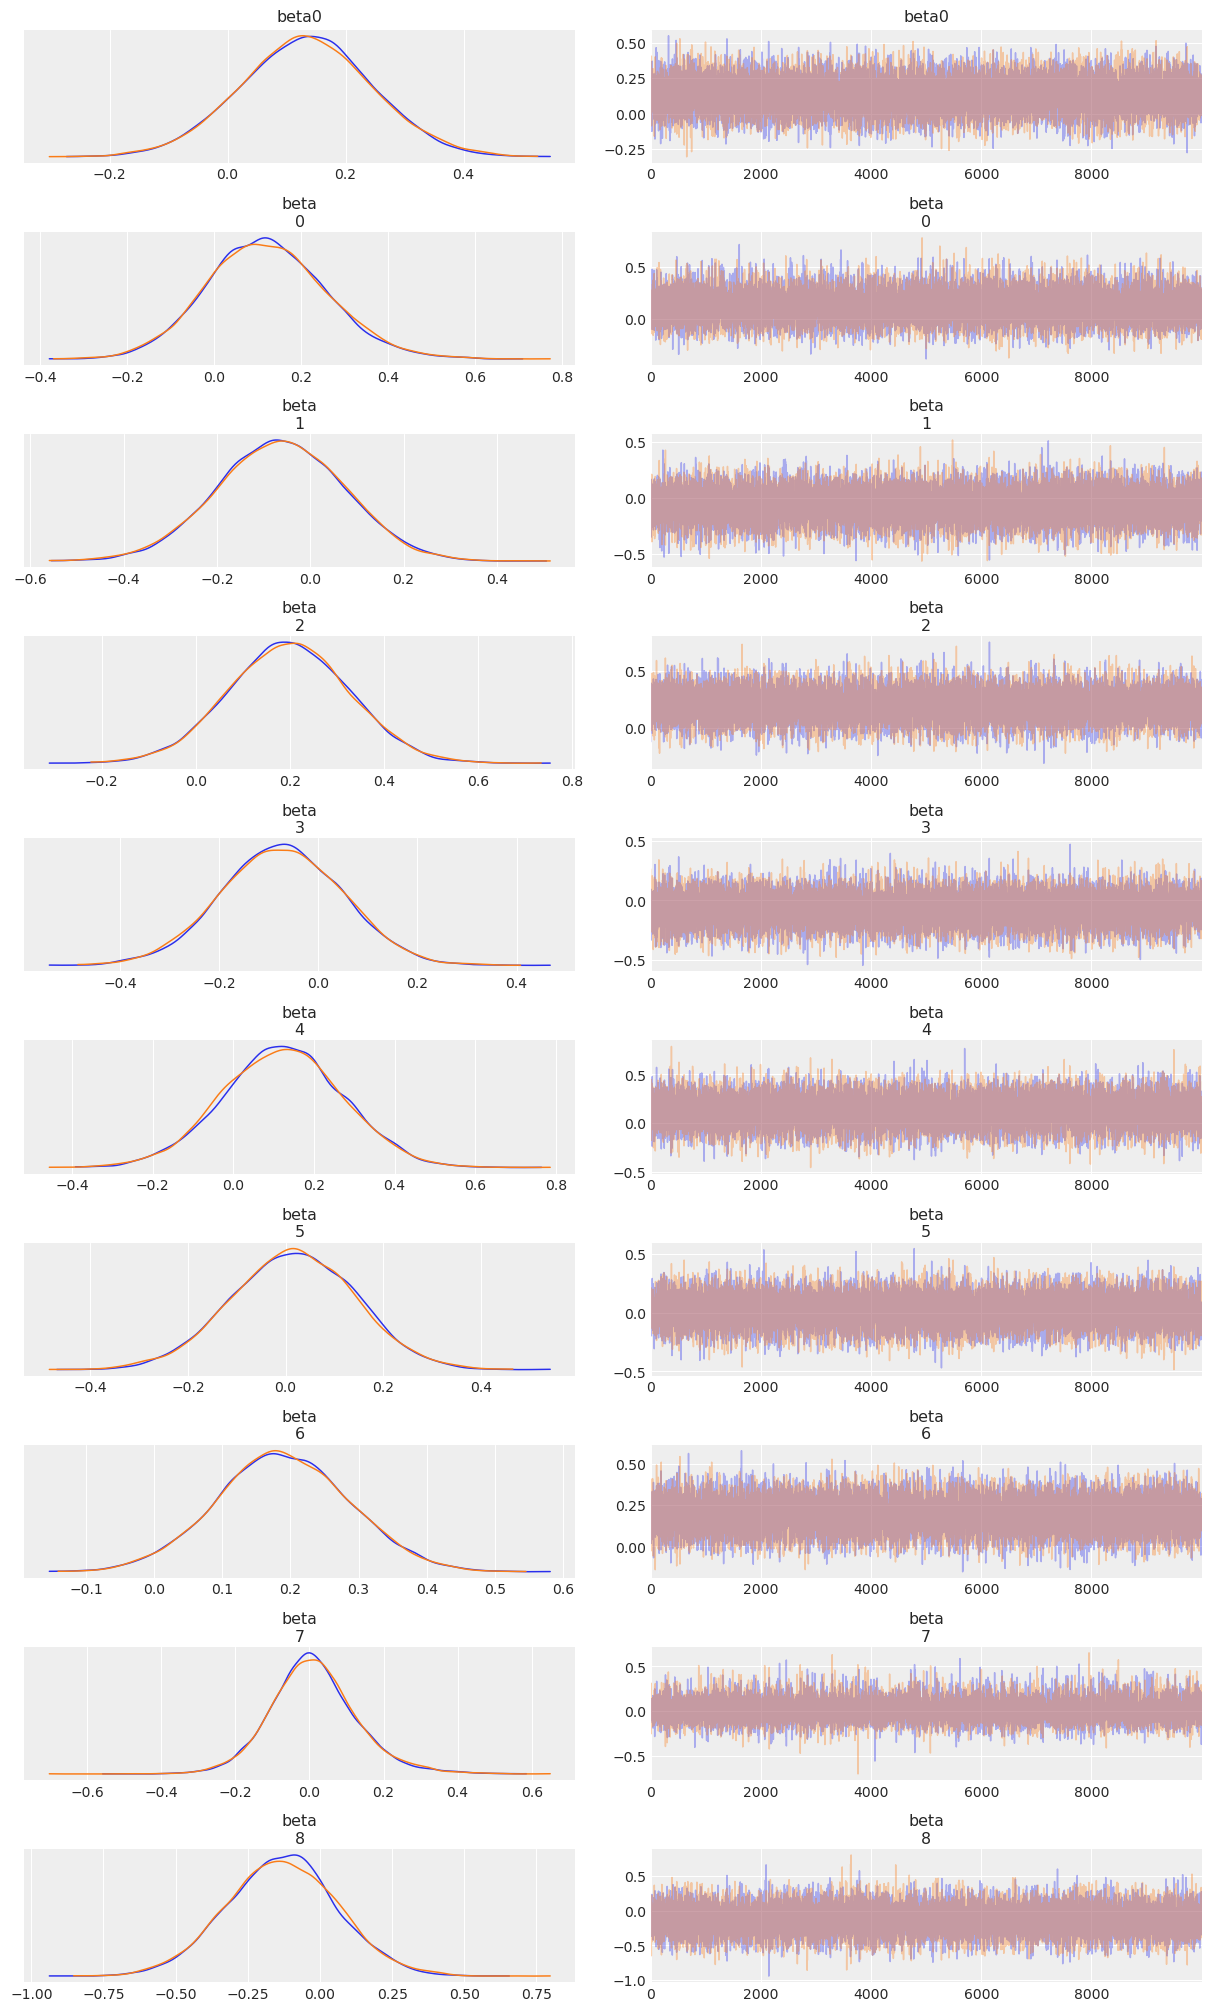

In [16]:
# Trace plots
with logistic_model:
    az.plot_trace(trace_main_logistic, var_names=['beta0','beta'])

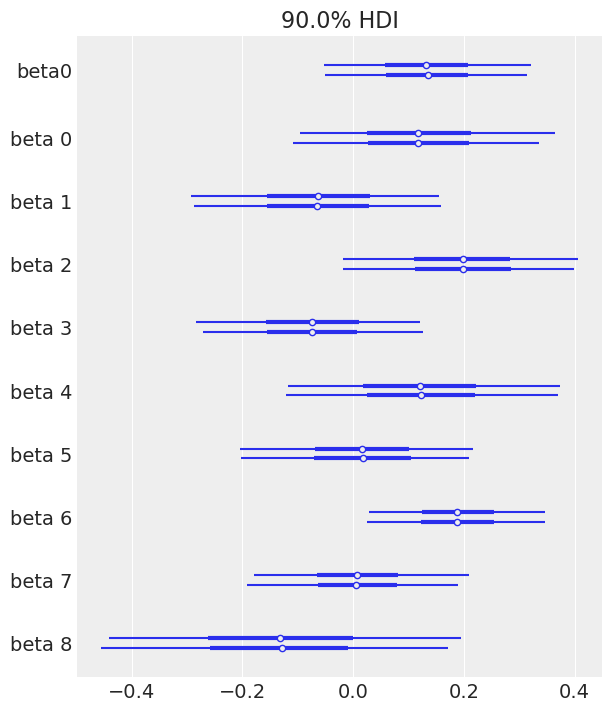

In [17]:
with logistic_model:
    pm.forestplot(trace_main_logistic, var_names=['beta0','beta'], hdi_prob=0.90)

### Posterior Distribution

This plot shows the predicted posterior distribution from many samples. The difference in predictions from one sample to another shows how much uncertainty we have in posterior predictions. The predicted logistic distributions are centered on the observed values, but have a high degree of uncertainty. With this high uncertainty, our model is probably not very useful for prediction.

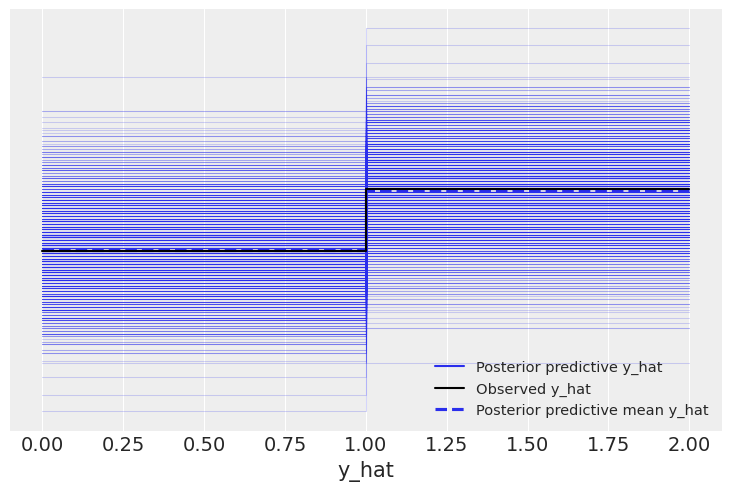

In [18]:
with logistic_model:
    ppc = pm.sample_posterior_predictive(trace_main_logistic, var_names=['y_hat', 'beta', 'beta0'], random_seed=random_seed)
    idata = az.from_pymc3(trace_main_logistic, posterior_predictive=ppc)
    az.plot_ppc(idata, num_pp_samples = 1000);

### Implement ADVI Approximation

In [19]:
with logistic_model:
    # Sample
    trace_advi_logistic = pm.fit(50000, method = 'advi', random_seed=random_seed)

Finished [100%]: Average Loss = 376.14


In [20]:
# sample from the variational posterior distribution
PPC_SAMPLES = 10000
advi_trace = trace_advi_logistic.sample(PPC_SAMPLES)

### Plot posteriors from sampling (blue) and ADVI (red)

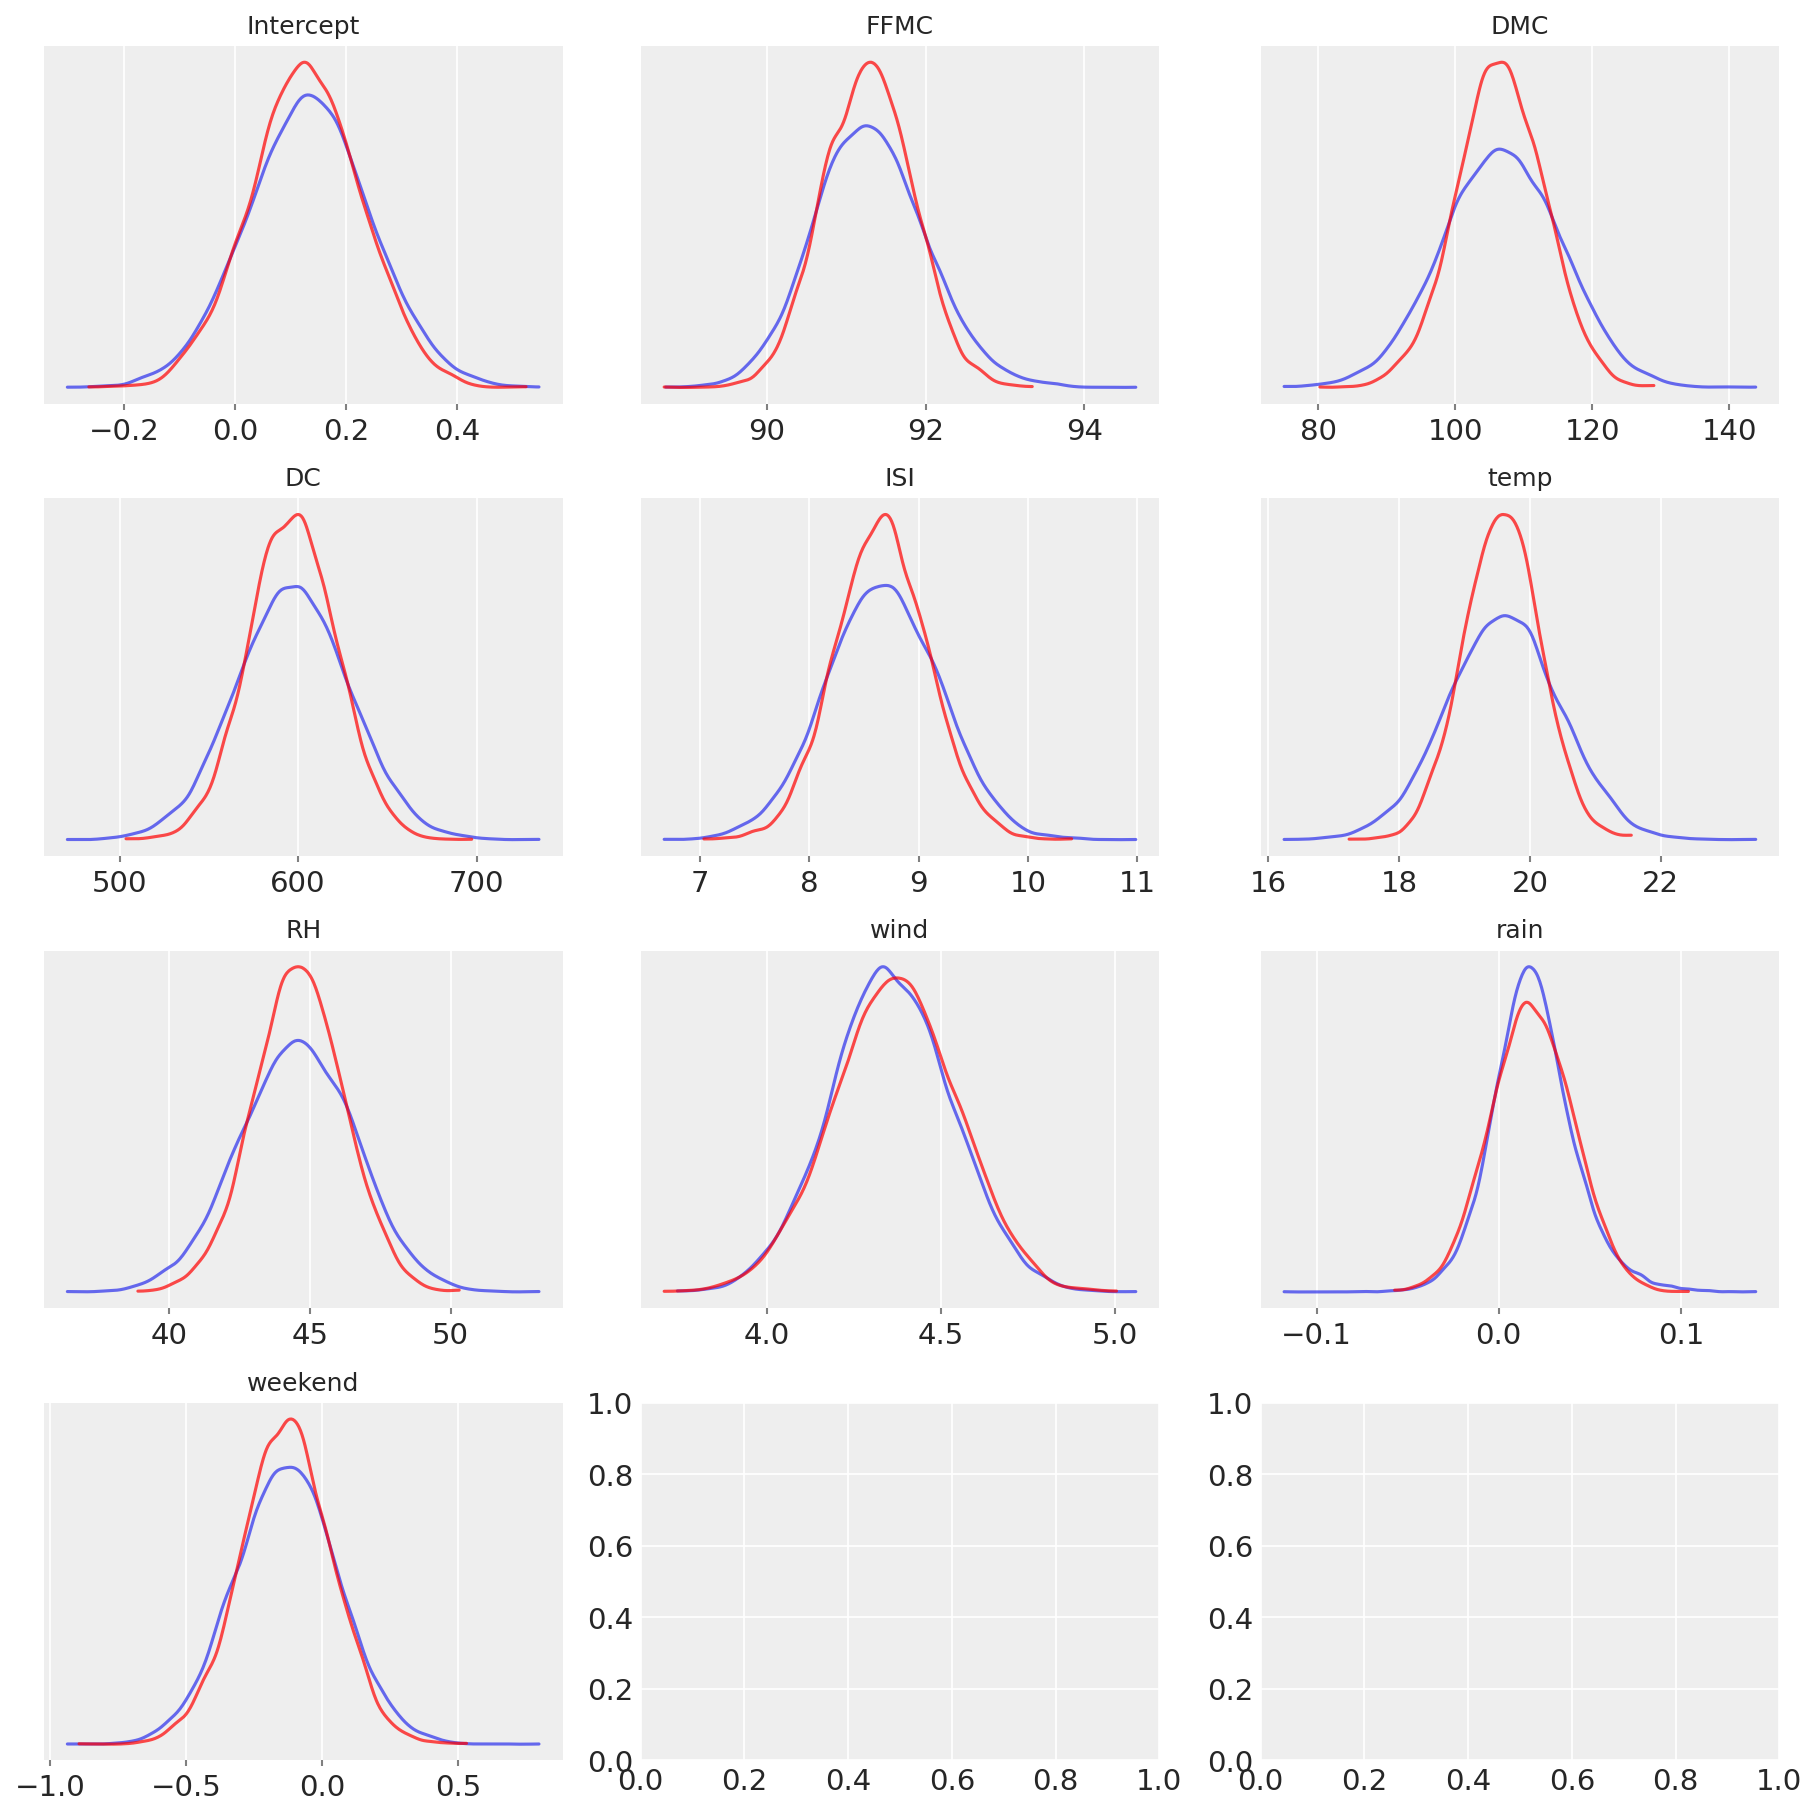

In [21]:
# Transform parameters back to original scale

def unstandardize(betas, df, df_original):
    result = np.copy(betas)
    for i, feature_name in enumerate(df.columns):
        if feature_name in df_original.columns and \
          df_original[feature_name].dtype in ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']:
            mean = df_original[feature_name].mean()
            std = df_original[feature_name].std()
            result[:, i] = result[:, i]*std + mean
    return result

burnin = 100

intercept = trace_main_logistic['beta0'][burnin:]
beta = trace_main_logistic['beta'][burnin:]

advi_intercept = advi_trace['beta0']
advi_beta = advi_trace['beta']

beta_unstandardized = unstandardize(beta, x_logistic_dummies, x_logistic)
advi_beta_unstandardized = unstandardize(advi_beta, x_logistic_dummies, x_logistic)

# Plot posteriors
fig, axes = plt.subplots(4,3, figsize=(12,12), dpi=150)
for ax, estimate_sampling, estimate_advi, title, xlabel in zip(fig.axes,
                               [intercept] + [beta_unstandardized[:,i] for i in range(k)],
                               [advi_intercept] + [advi_beta_unstandardized[:,i] for i in range(k)],
                               ['Intercept'] + x_logistic_dummies.columns.tolist(),
                               ['Intercept'] + x_logistic_dummies.columns.tolist()):
    pm.plot_posterior(estimate_sampling, ax=ax,point_estimate=None, hdi_prob= 'hide',  alpha=0.7)
    pm.plot_posterior(estimate_advi, ax=ax, color='red', point_estimate=None, hdi_prob= 'hide', alpha=0.7)
    ax.set_title(title, fontsize=12)
plt.show()

## Bayesian Linear Regression Model
Find the likely burn area when a fire occurs

In [22]:
k = x_linear_dummies.shape[1] # number of predictors

with pm.Model() as linear_model:
    
    # Intercept term & prior
    beta0 = pm.Normal('beta0', mu=0, sd=1)
    # Beta coefficients for predictor variables & priors
    beta = pm.MvNormal('beta', mu=np.zeros(k), cov=np.eye(k), shape=k)
    
    mu = beta0 + pm.math.dot(x_linear_dummies, beta)
    sigma =  pm.HalfCauchy('sigma', 1e5)
    
    y_hat = pm.Normal('y_hat', mu=mu, sigma=sigma, observed=y_linear)
    
    # Sample
    trace_main_linear = pm.sample(10000, cores = 1, random_seed=random_seed)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta, beta0]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 61 seconds.


### Graphical Representation of Model

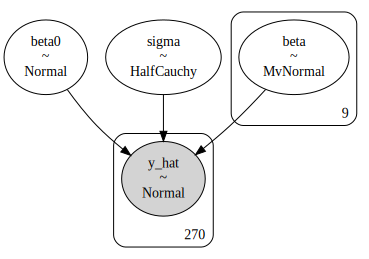

In [23]:
# The graphical model
pm.model_to_graphviz(linear_model)

### Coefficient Distributions

Forest plots show that DMC, ISI, RH, and weekend are the most siginificant predictors since their 90% HCI do not (or just barely) cross a mean of 0. DMC has a positive coefficient so burn area increases with it. DMC measures moisture content of organic matter in the forest with higher numbers on drier days, so fires should tend to spread as easily with lower moisture content. RH has a negative coefficients to chance of fire decreases with those. A negative coefficient on RH makes sense since fires do not spread as easily in humid conditions. Our intuition had told us that higher winds (higher ISI) would tend to spread a fire to larger areas and feed it oxygen, so a positive coefficient was expected. Maybe the negative coefficient we calculated is explained by wind tending to extinguish a small fire before they spread. Weekend has a positive coefficient and this may be explained by many fires being having a human cause and people are off work on weekends. There may also be less firefighters on staff on weekends, but we could not confirm this.

In [24]:
# Results in table
with linear_model:
    main_idata = az.from_pymc3(trace_main_linear)
az.summary(main_idata, var_names=['beta0','beta'], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta0,2.42,0.16,2.13,2.73,0.0,0.0,22525.07,22488.94,22532.23,15833.65,1.0
beta[0],0.04,0.21,-0.36,0.44,0.0,0.0,22751.25,9824.81,22806.82,14995.80,1.0
beta[1],0.29,0.20,-0.09,0.66,0.0,0.0,18970.32,17087.19,18986.97,16221.33,1.0
beta[2],-0.09,0.19,-0.43,0.27,0.0,0.0,22488.04,13766.56,22507.14,16306.07,1.0
beta[3],-0.29,0.20,-0.66,0.09,0.0,0.0,19118.90,17681.52,19104.68,15051.84,1.0
beta[4],-0.19,0.22,-0.59,0.23,0.0,0.0,15983.02,14530.74,15963.25,15869.86,1.0
beta[5],-0.30,0.17,-0.62,0.03,0.0,0.0,15849.44,15348.34,15881.90,15727.85,1.0
beta[6],0.14,0.15,-0.12,0.44,0.0,0.0,24130.68,17015.44,24128.21,15684.53,1.0
beta[7],0.06,0.14,-0.20,0.31,0.0,0.0,30888.29,11275.78,30866.20,15074.21,1.0
beta[8],0.60,0.28,0.05,1.12,0.0,0.0,20388.38,18651.23,20393.63,15351.41,1.0


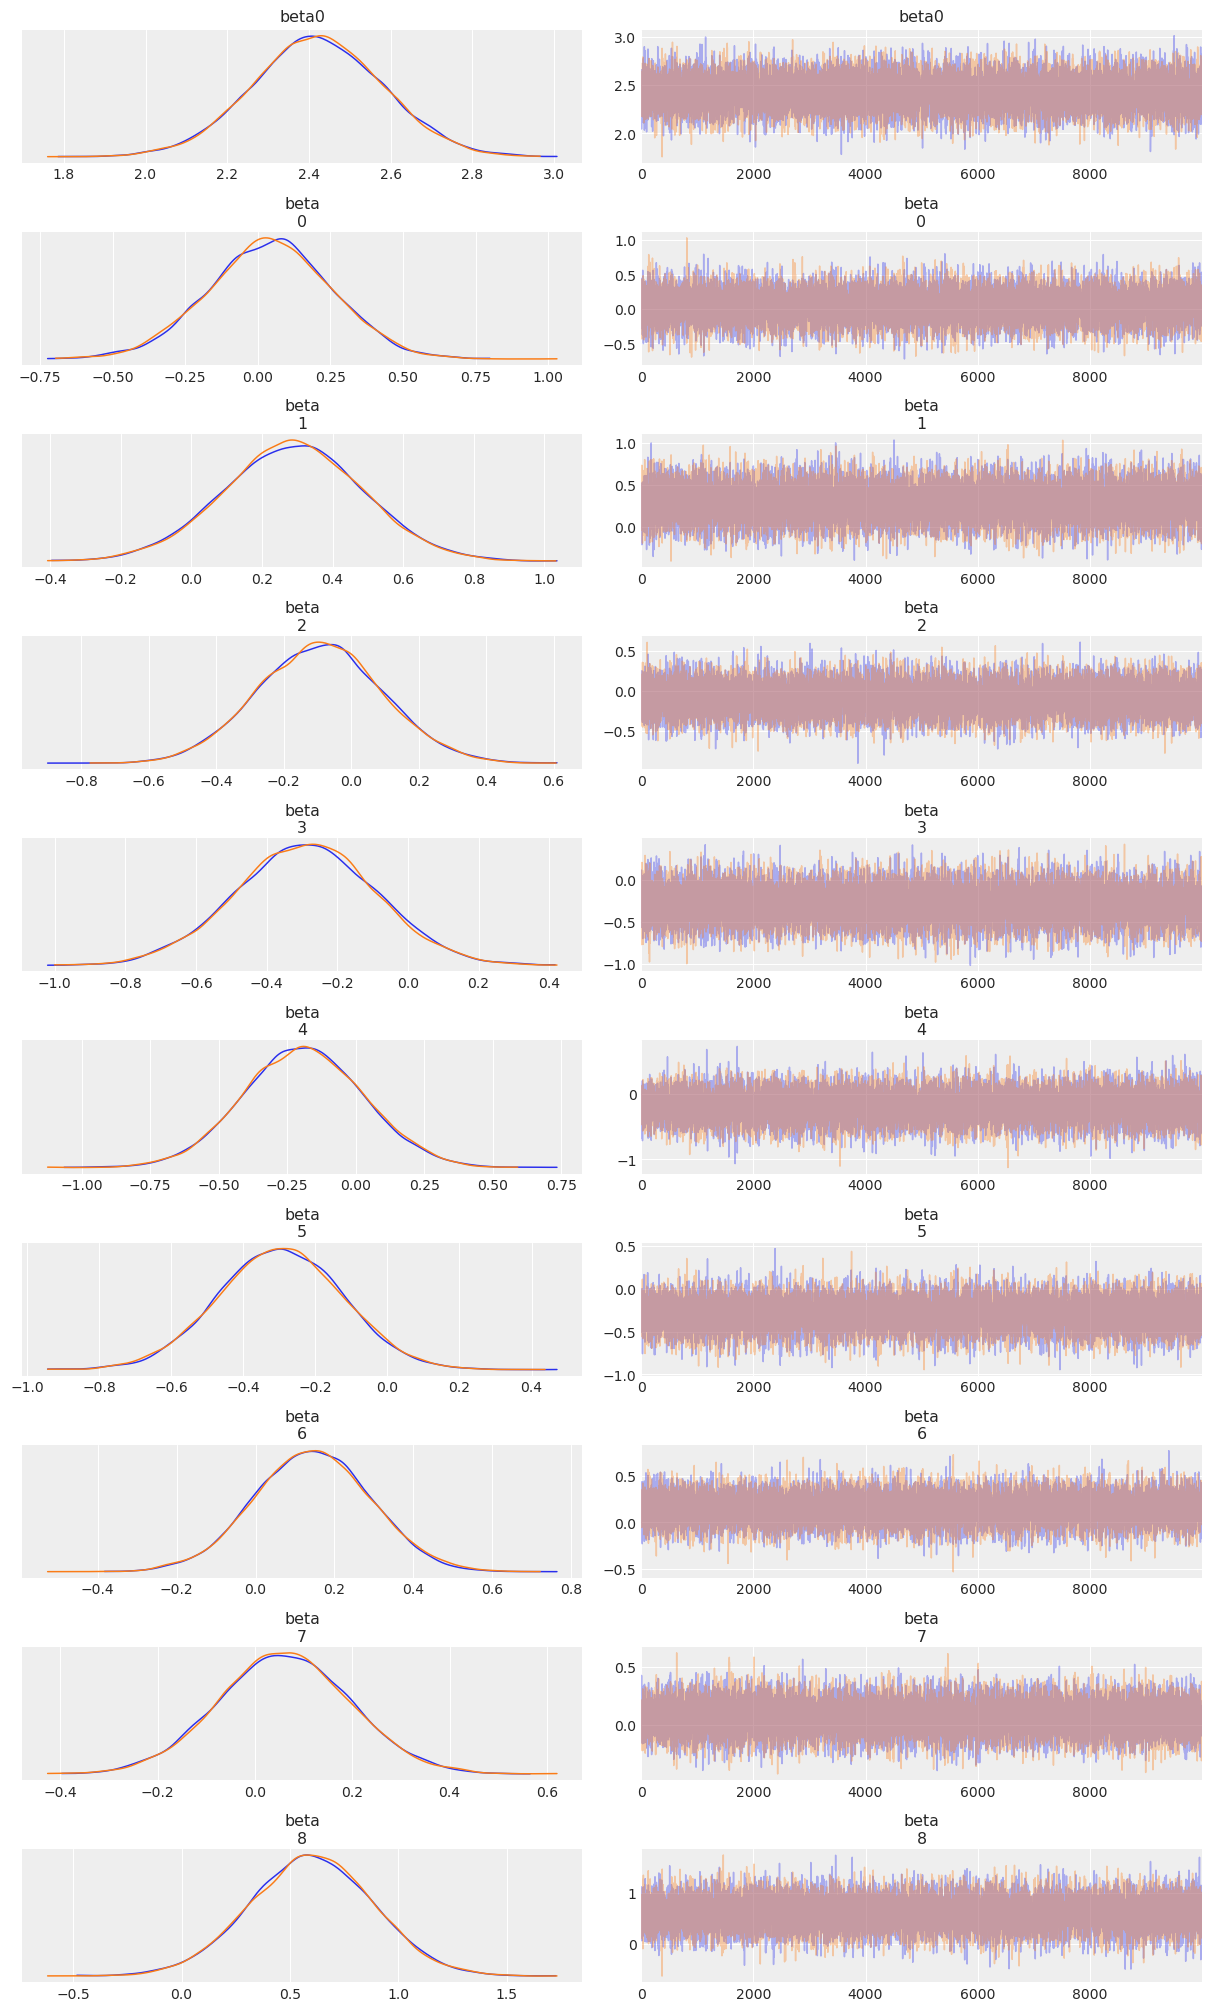

In [25]:
# Trace plots
with linear_model:
    az.plot_trace(trace_main_linear, var_names=['beta0','beta'])

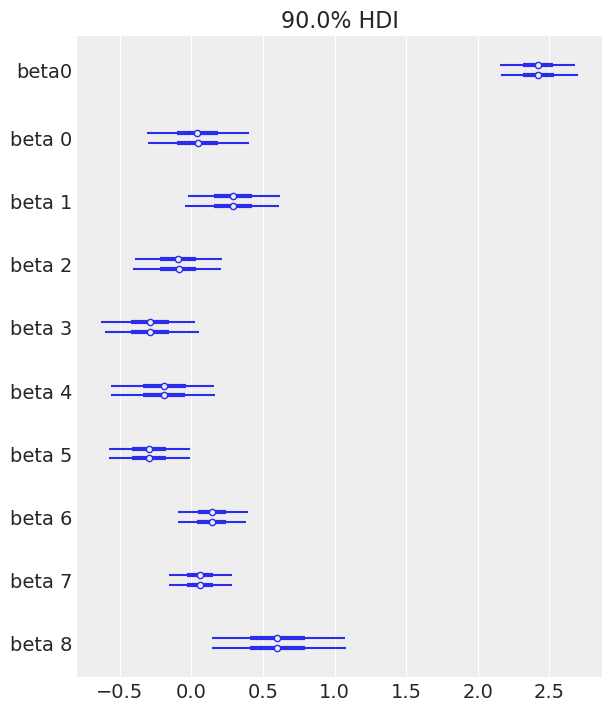

In [26]:
with linear_model:
    pm.forestplot(trace_main_linear, var_names=['beta0','beta'], hdi_prob=0.90)

### Posterior Distribution

This plot shows the predicted posterior distribution from many samples. The difference in predictions from one sample to another shows how much uncertainty we have in posterior predictions. The samples have a good bit of uncertainty, but the predicted normal distributions do tend to hug the observed values fairly well.

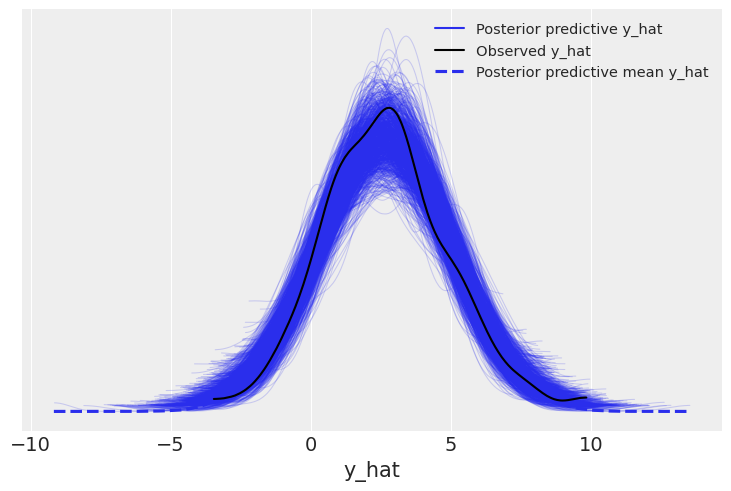

In [27]:
with linear_model:
    ppc = pm.sample_posterior_predictive(trace_main_linear, var_names=['y_hat'], random_seed=random_seed)
    idata = az.from_pymc3(trace_main_linear, posterior_predictive=ppc)
    az.plot_ppc(idata, num_pp_samples = 1000);

### Implement ADVI Approximation

In [28]:
with linear_model:
    # Sample
    trace_advi_linear = pm.fit(50000, method = 'advi', random_seed=random_seed)

Finished [100%]: Average Loss = 625.43


In [29]:
# sample from the variational posterior distribution
PPC_SAMPLES = 10000
advi_trace = trace_advi_linear.sample(PPC_SAMPLES)

### Plot posteriors from sampling (blue) and ADVI (red)

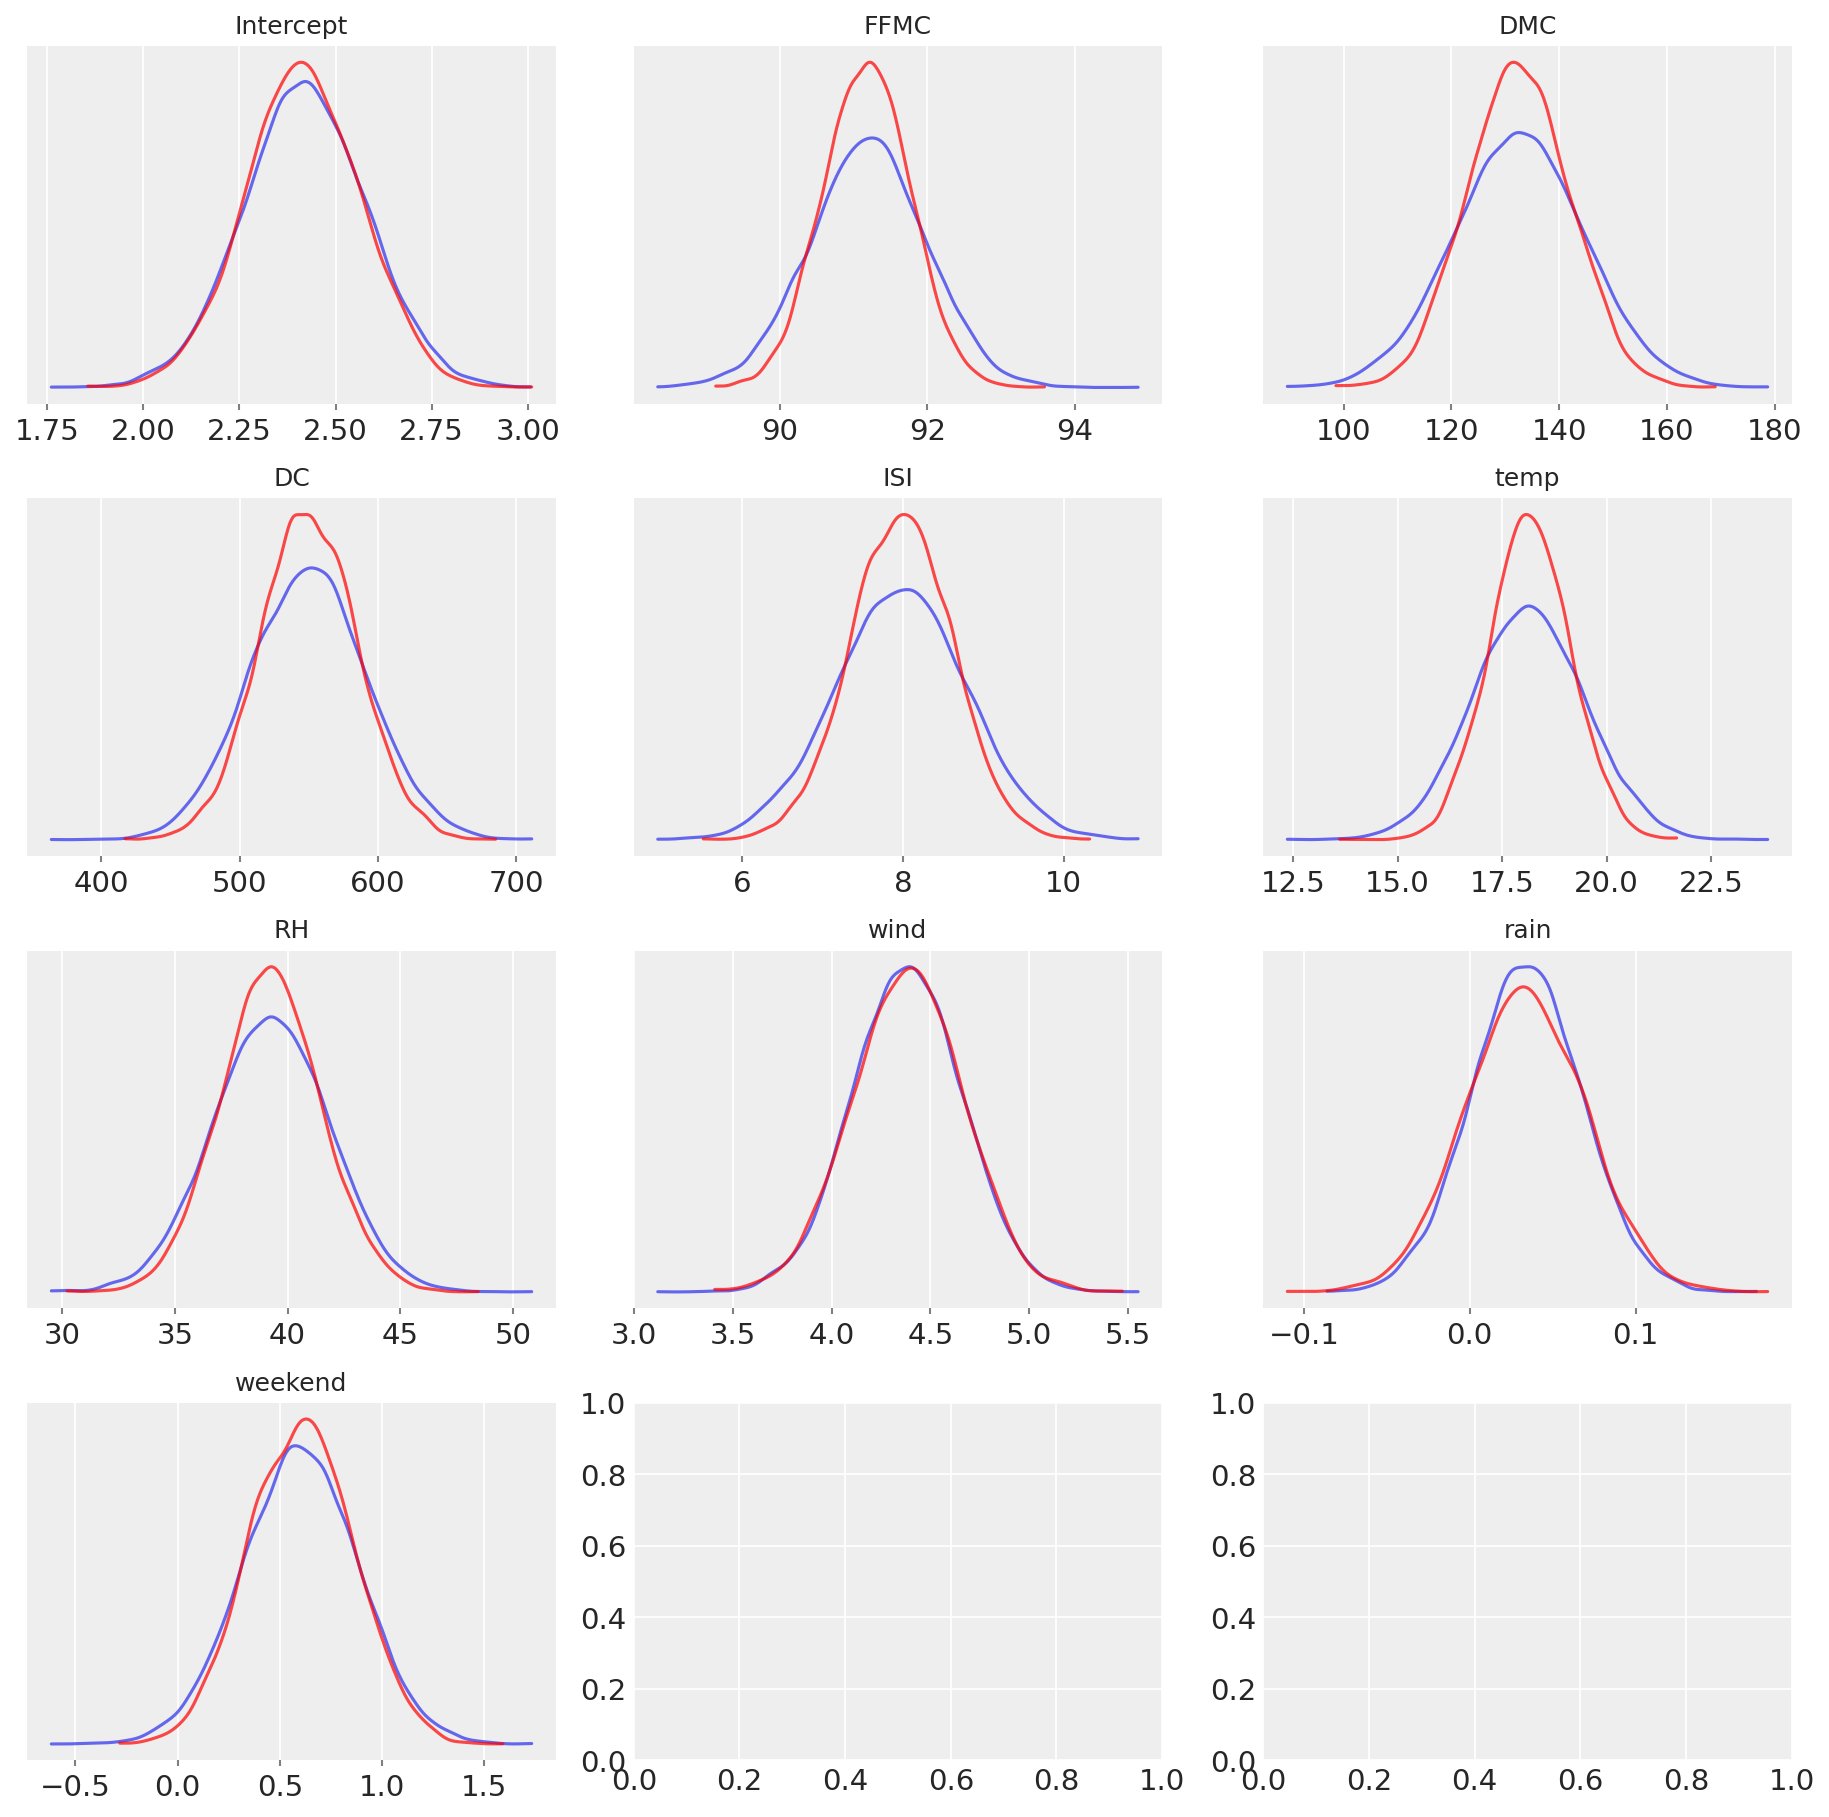

In [30]:
# Transform parameters back to original scale
burnin = 100

intercept = trace_main_linear['beta0'][burnin:]
beta = trace_main_linear['beta'][burnin:]

advi_intercept = advi_trace['beta0']
advi_beta = advi_trace['beta']

beta_unstandardized = unstandardize(beta, x_linear_dummies, x_linear)
advi_beta_unstandardized = unstandardize(advi_beta, x_linear_dummies, x_linear)

# Plot posteriors
fig, axes = plt.subplots(4,3, figsize=(12,12), dpi=150)
for ax, estimate_sampling, estimate_advi, title, xlabel in zip(fig.axes,
                               [intercept] + [beta_unstandardized[:,i] for i in range(k)],
                               [advi_intercept] + [advi_beta_unstandardized[:,i] for i in range(k)],
                               ['Intercept'] + x_linear_dummies.columns.tolist(),
                               ['Intercept'] + x_linear_dummies.columns.tolist()):
    pm.plot_posterior(estimate_sampling, ax=ax,point_estimate=None, hdi_prob= 'hide',  alpha=0.7)
    pm.plot_posterior(estimate_advi, ax=ax, color='red', point_estimate=None, hdi_prob= 'hide', alpha=0.7)
    ax.set_title(title, fontsize=12)
plt.show()